# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

### Import Dataset

### Initiation Directory

In [3]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [4]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale nilai piksel ke rentang [0, 1]
    zoom_range=0.2 #,            # Memperbesar gambar hingga 20%
    #fill_mode='nearest'        # Mengisi piksel yang kosong dengan piksel terdekat
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(256, 256),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 8
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(256, 256),
    class_mode='categorical',
    batch_size = 8
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


### Project Model

In [5]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(64, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(64, return_sequences=True)))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 16384)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 8, 128)            8421888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 128)            98816     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 32,113,541
Trainable params: 8,525,829
Non-trainable params: 23,587,712
____________________________________

In [8]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
760/760 [==============================] - 138s 170ms/step - loss: 1.5907 - acc: 0.2433 - val_loss: 1.5435 - val_acc: 0.2393
Epoch 2/30
760/760 [==============================] - 105s 138ms/step - loss: 1.4858 - acc: 0.3562 - val_loss: 1.2949 - val_acc: 0.5051
Epoch 3/30
760/760 [==============================] - 105s 138ms/step - loss: 1.3606 - acc: 0.4135 - val_loss: 1.1818 - val_acc: 0.5071
Epoch 4/30
760/760 [==============================] - 105s 138ms/step - loss: 1.2720 - acc: 0.4416 - val_loss: 1.1498 - val_acc: 0.4908
Epoch 5/30
760/760 [==============================] - 105s 138ms/step - loss: 1.2259 - acc: 0.4711 - val_loss: 1.0377 - val_acc: 0.5601
Epoch 6/30
760/760 [==============================] - 105s 138ms/step - loss: 1.1722 - acc: 0.5021 - val_loss: 1.0034 - val_acc: 0.5794
Epoch 7/30
760/760 [==============================] - 108s 142ms/step - loss: 1.1643 - acc: 0.4998 - val_loss: 1.1410 - val_acc: 0.4745
Epoch 8/30
760/760 [============================

In [ ]:
model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

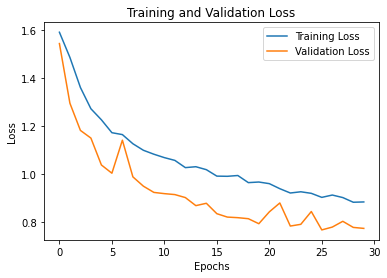

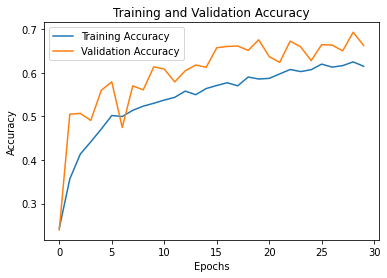

In [9]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 41ms/step - loss: 0.7736 - acc: 0.6629
Loss: 0.7735523581504822
Accuracy: 0.662932813167572


In [11]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



760/760 [==============================] - 97s 125ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21003   0.12705   0.15832      1220
            covid19    0.20789   0.11022   0.14406      1243
             normal    0.22311   0.42996   0.29378      1235
       tuberculosis    0.18296   0.11197   0.13892      1170
    viral_pneumonia    0.20605   0.26980   0.23365      1212

           accuracy                        0.21069      6080
          macro avg    0.20601   0.20980   0.19375      6080
       weighted avg    0.20625   0.21069   0.19420      6080



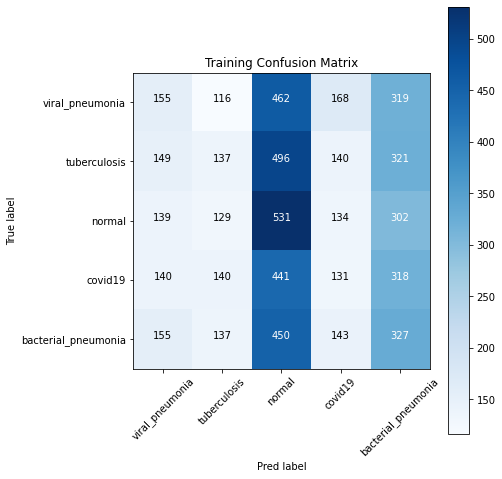

In [13]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [5]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


### Our Model

In [6]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(64, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(64, return_sequences=True)))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 4096)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 8, 128)            2130432   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 128)            98816     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 22,258,757
Trainable params: 2,234,373
Non-trainable params: 20,024,384
____________________________________

In [7]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
760/760 [==============================] - 162s 196ms/step - loss: 1.3641 - acc: 0.4977 - val_loss: 0.9408 - val_acc: 0.6976
Epoch 2/30
760/760 [==============================] - 117s 154ms/step - loss: 0.8858 - acc: 0.6643 - val_loss: 0.7073 - val_acc: 0.7291
Epoch 3/30
760/760 [==============================] - 116s 152ms/step - loss: 0.7107 - acc: 0.7171 - val_loss: 0.5925 - val_acc: 0.7597
Epoch 4/30
760/760 [==============================] - 116s 152ms/step - loss: 0.6348 - acc: 0.7495 - val_loss: 0.5442 - val_acc: 0.7862
Epoch 5/30
760/760 [==============================] - 116s 152ms/step - loss: 0.5722 - acc: 0.7701 - val_loss: 0.5089 - val_acc: 0.7933
Epoch 6/30
760/760 [==============================] - 115s 151ms/step - loss: 0.5375 - acc: 0.7791 - val_loss: 0.4630 - val_acc: 0.8157
Epoch 7/30
760/760 [==============================] - 114s 150ms/step - loss: 0.5046 - acc: 0.7988 - val_loss: 0.4629 - val_acc: 0.8167
Epoch 8/30
760/760 [============================

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


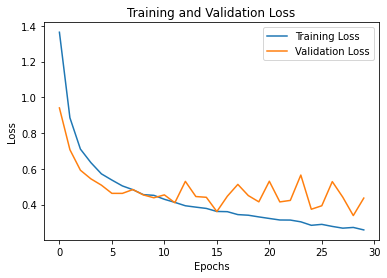

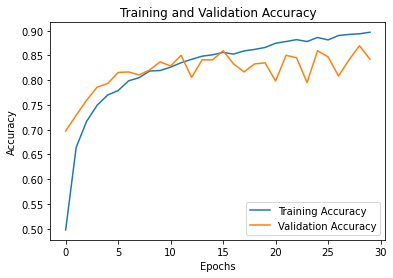

In [8]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 50ms/step - loss: 0.4366 - acc: 0.8422
Loss: 0.4365590512752533
Accuracy: 0.842158854007721


In [10]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



760/760 [==============================] - 114s 148ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19256   0.19098   0.19177      1220
            covid19    0.22179   0.22767   0.22469      1243
             normal    0.18919   0.17004   0.17910      1235
       tuberculosis    0.19544   0.20513   0.20017      1170
    viral_pneumonia    0.21338   0.22112   0.21718      1212

           accuracy                        0.20296      6080
          macro avg    0.20247   0.20299   0.20258      6080
       weighted avg    0.20255   0.20296   0.20261      6080



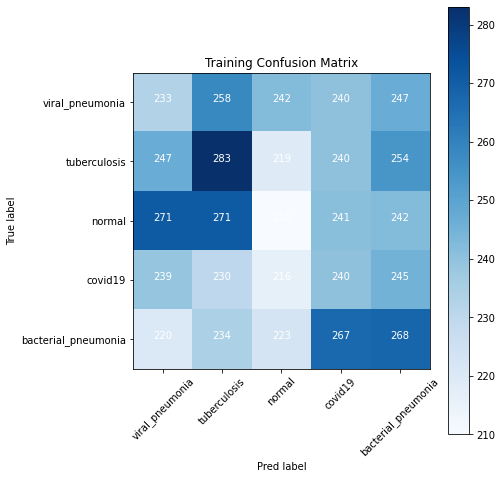

In [12]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [13]:
InceptionV3_model = InceptionV3(weights='imagenet', 
                                include_top=False, input_shape=(256, 256, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [14]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 12288)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6, 128)            6324736   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 6, 128)            98816     
_________________________________________________________________
flatten_3 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3845      
Total params: 28,230,181
Trainable params: 6,427,397
Non-trainable params: 21,802,784
__________________________________

In [15]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
760/760 [==============================] - 133s 161ms/step - loss: 1.0030 - acc: 0.6382 - val_loss: 0.7165 - val_acc: 0.7118
Epoch 2/30
760/760 [==============================] - 119s 157ms/step - loss: 0.6688 - acc: 0.7451 - val_loss: 0.5965 - val_acc: 0.7668
Epoch 3/30
760/760 [==============================] - 120s 158ms/step - loss: 0.5711 - acc: 0.7757 - val_loss: 0.5434 - val_acc: 0.7749
Epoch 4/30
760/760 [==============================] - 120s 158ms/step - loss: 0.5087 - acc: 0.7982 - val_loss: 0.5087 - val_acc: 0.7760
Epoch 5/30
760/760 [==============================] - 116s 152ms/step - loss: 0.4565 - acc: 0.8248 - val_loss: 0.4751 - val_acc: 0.7974
Epoch 6/30
760/760 [==============================] - 119s 157ms/step - loss: 0.4104 - acc: 0.8398 - val_loss: 0.4891 - val_acc: 0.7923
Epoch 7/30
760/760 [==============================] - 123s 161ms/step - loss: 0.3851 - acc: 0.8520 - val_loss: 0.4506 - val_acc: 0.8126
Epoch 8/30
760/760 [============================

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

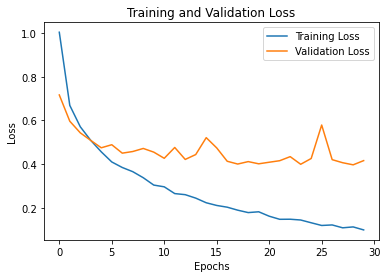

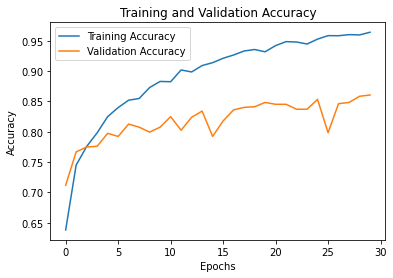

In [16]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 49ms/step - loss: 0.4165 - acc: 0.8605
Loss: 0.41647517681121826
Accuracy: 0.860488772392273


In [18]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



760/760 [==============================] - 114s 147ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21949   0.21967   0.21958      1220
            covid19    0.21388   0.21319   0.21354      1243
             normal    0.19304   0.19757   0.19528      1235
       tuberculosis    0.18728   0.18376   0.18550      1170
    viral_pneumonia    0.19123   0.19059   0.19091      1212

           accuracy                        0.20115      6080
          macro avg    0.20098   0.20096   0.20096      6080
       weighted avg    0.20114   0.20115   0.20114      6080



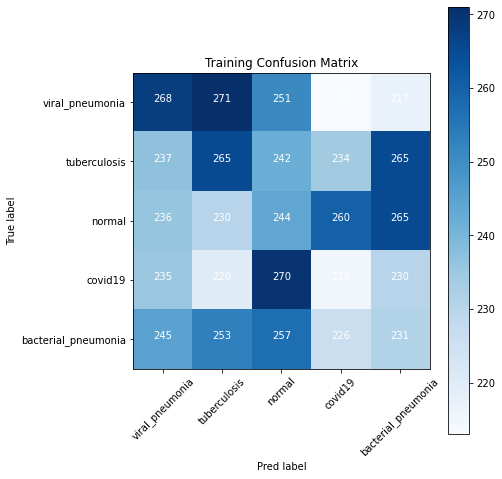

In [19]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()